In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
%matplotlib inline

In [7]:
words = pd.read_table('names.txt', header=None, names=['name'])
words[:5]

,name
0,emma
1,olivia
2,ava
3,isabella
4,sophia


In [9]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words['name']))))
char_to_idx = {s:i+1 for i,s in enumerate(chars)}
char_to_idx['.'] = 0
idx_to_char = {i:s for s,i in char_to_idx.items()}
vocab_size = len(idx_to_char)
print(idx_to_char)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [191]:
def build_dataset(words, block_size = 3):
    # first, initialize X and Y sets
    X, Y = [], []

    for w in words:
        # use the 3 previous characters to predict the next character (similar to trigram approach):
        context = [0] * block_size
        for ch in w + '.':
            idx = char_to_idx[ch]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx]
    

    X, Y = torch.tensor(X), torch.tensor(Y)

    return X, Y

def build_model(vocab_size, n_emb, n_hidden, block_size = 3):
    # initialize the parameters of the model
    C = torch.randn((vocab_size, n_emb))

    # to initialize these, let's use Kaiming's Normalization numbers
    W1 = torch.randn((n_emb * block_size, n_hidden)) * (5/3)/(n_emb * block_size) ** 0.5
    # b1 = torch.randn(n_hidden) * 0.1
    W2 = torch.randn((n_hidden, vocab_size)) * 0.1
    b2 = torch.randn(vocab_size) * 0.01
    bngain = torch.ones((1, n_hidden))
    bnbias = torch.zeros((1, n_hidden))    
    bnmean_running = torch.zeros((1, n_hidden))
    bnstd_running = torch.ones((1, n_hidden))

    return [C, W1, W2, b2, bngain, bnbias], [bnmean_running, bnstd_running]

def train_model(Xtr, Ytr, Xte, Yte, grad_parameters, running_parameters, batch_size = 32, learning_rate = 0.1, epochs = 20000, return_running = False):
    C, W1, W2, b2, bngain, bnbias = grad_parameters
    bnmean_running, bnstd_running = running_parameters

    loss_i = []

    for p in grad_parameters:
        p.requires_grad = True

    for _ in range(epochs):
        # implement stochastc gradient descent to train the model
        ix = torch.randint(0, Xtr.shape[0], (batch_size,))

        # embedding vector
        emb = C[Xtr[ix]]

        # first layer
        embcat = emb.view(emb.shape[0], -1)

        # make the numbers roughy Gaussian with batch normalization
        hpreact = embcat @ W1 #+ b1
        bn_mean = hpreact.mean(dim = 0, keepdim = True)
        bn_std = hpreact.std(dim = 0, keepdim = True)
        hpreact = bngain * (hpreact - bn_mean) / bn_std + bnbias

        with torch.no_grad():
            bnmean_running = 0.99 * bnmean_running + 0.01 * bn_mean
            bnstd_running = 0.99 * bnstd_running + 0.01 * bn_std

        h = torch.tanh(hpreact)

        # second layer (non-linaerity)
        logits = (h @ W2) + b2

        # cross entropy loss
        loss = F.cross_entropy(logits, Ytr[ix])

        # make sure gradients aren't adding on top of each other
        for p in grad_parameters:
            p.grad = None
        
        # backwards pass
        loss.backward()

        # update parameters
        if _ // 10000 == 1:
            learning_rate = 0.01

        for p in grad_parameters:
            p.data -= learning_rate * p.grad

        # if _ % 1000 == 0:
        #     print(f'{_:7d}/{epochs:7d}: {loss.item():.4f}')
        loss_i.append(np.log10(loss.item()))

    # plot the loss
    plt.plot(loss_i)

    # find total loss based on Yte
    emb = C[Xte]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bn_mean) / bn_std + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yte)

    if return_running:
        return loss, [bnmean_running, bnstd_running]
    else:
        return loss


In [192]:
import random 

all_names = words['name']
random.shuffle(all_names)
n1 = int(0.8 * all_names.shape[0])
n2 = int(0.9 * all_names.shape[0])

Xtr, Ytr = build_dataset(all_names[:n1])
Xva, Yva = build_dataset(all_names[n1:n2])
Xte, Yte = build_dataset(all_names[n2:])

In [193]:
grad_parameters, running_parameters = build_model(27, 10, 300)

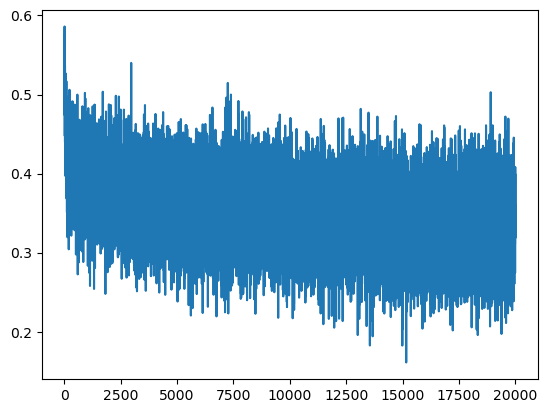

In [194]:
loss, running_params = train_model(Xtr, Ytr, Xva, Yva, grad_parameters, running_parameters, return_running = True) 

In [196]:
C, W1, W2, b2, bngain, bnbias = grad_parameters

# we cam use the running values initialized in the training function instead of explicitly calling them
bnmean_running, bnstd_running = running_params
epsilon = 1e-5

In [199]:
@torch.no_grad() # this decorator disables gradient tracking

def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xva, Yva),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 #+ b1
  hpreact = bngain * (hpreact - bnmean_running) / (bnstd_running + epsilon) + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 2.1669249534606934
val 2.181821584701538
test 2.198303699493408


Some ways we've improved the mode so far:
1) Fixing the softmaxing
2) Adjust the randomness of the parameters by making them smaller, inadvertently also fixing the tanh layer
2) Fixing the tanh layer

In [229]:
# Samplign from the Neural Network

for _ in range(20):
    output = []
    context = [0] * 3
    while True:
        emb = C[torch.tensor(context).view(1, -1)]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1
        hpreact = bngain * (hpreact - bnmean_running) / (bnstd_running + epsilon) + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        p = F.softmax(logits, dim=1)
        idx = torch.multinomial(p, 1).item()
        if idx == 0:
            break
        output.append(idx)
        context = context[1:] + [idx]
        if idx == 0:
            break

    # print(output)
    print(''.join(idx_to_char[i] for i in output))

dee
abriana
ameah
ryce
nomia
aylinden
nestor
oluwaprez
ableantyn
kalakonnellae
rohiannet
harani
jnen
ioghedmeruto
shart
han
tchis
novannahdise
sroanen
braedyn


In [216]:
# one problem with the tanh, sigmoid, and RELU activation functions are that they have the potential to squash an entire neuron, which is called the vanishing gradient problem.
# One activation function to solve this problem is by 